## Fraud is a Booming Business
According to a report in the USA, the financial fraud expected to increase to $12 billion by 2020 which is more than PayPal or MasterCard current revenues.

Fraud Detection Algorithms

Many major banks are still replying on old rules-based expert systems to detect fraud, but these systems have proved all too easy to beat. The financial services industry is relying on increasingly complex fraud detection algorithms. Many in the financial services industry have updated their fraud detection to include some basic ML algorithms including various clustering classifiers, linear approaches, and support vector machines etc. The most advanced companies in the financial services industry, such as PayPal, have been pioneering advanced AI techniques such as deep neural networks and autoencoders. 

This dataset is with information on the rising risk of digital financial fraud, emphasizing the difficulty in obtaining such data. The main technical challenge it poses to predicting fraud is the highly imbalanced distribution between positive and negative classes in 6 million rows of data. Another stumbling block to the utility of this data stems from the possible discrepancies in its description. The goal of this analysis is to solve both these issues by a detailed data exploration and cleaning followed by choosing a suitable ML algorithm to deal with the skew. 

In [1]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('bank_fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.isnull().values.any() # checking if any null values

False

In [4]:
df.describe

<bound method NDFrame.describe of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
5           1   PAYMENT     7817.71    C90045638       53860.00   
6           1   PAYMENT     7107.77   C154988899      183195.00   
7           1   PAYMENT     7861.64  C1912850431      176087.23   
8           1   PAYMENT     4024.36  C1265012928        2671.00   
9           1     DEBIT     5337.77   C712410124       41720.00   
10          1     DEBIT     9644.94  C1900366749        4465.00   
11          1   PAYMENT     3099.97   C249177573       20771.00   
12          1   PAYMENT     2560.74  C1648232591        5070.00   
13          1   PAYMENT    1

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


This is a large dataset with well over six-million entries. Let’s have a look at the data dictionary so we know what kind of information we have:

 - step - Our database is as follows. Step indicates hour, for example, 1 step means 1 hour. The total number of steps is 744,
   which represents transactions for 1 month.
 - type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
 - amount - amount of the transaction in local currency.
 - nameOrig - customer who started the transaction
 - oldbalanceOrg - initial balance before the transaction
 - newbalanceOrig - new balance after the transaction
 - nameDest - customer who is the recipient of the transaction
 - oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that
   start with M (Merchants).
 - newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start
   with M (Merchants).
 - isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the
   fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by
   transferring to another account and then cashing out of the system.
 - isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal
   attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

A part of our task will be to improve as much on isFlaggedFraud as possible. It represents a typical rules-based heuristic for identifying fraud.

#### Let's visualise the type of transactions

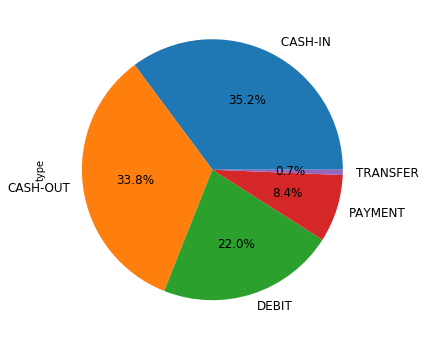

In [6]:
fig = plt.figure(figsize=(10,6))
ax = (df['type'].value_counts()*100.0 /len(df))\
.plot.pie(autopct='%.1f%%', labels = [' CASH-IN', 'CASH-OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
         fontsize=12)                                                                           
plt.show()

#### How much money are we talking about (synthetically)?

Text(0, 0.5, 'sum(amounts)')

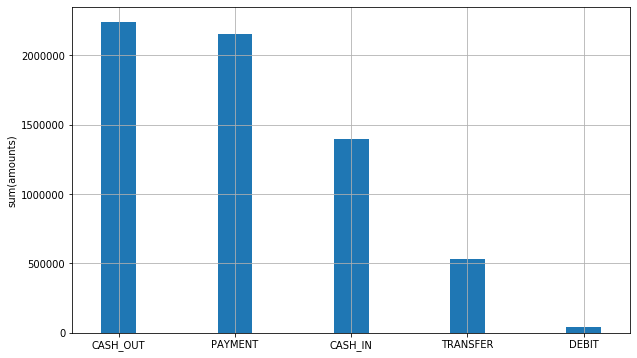

In [11]:
ax = df['type'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3,
                                   figsize = (10, 6), grid=True)
ax.set_ylabel('sum(amounts)')


#### How many and what % of fraud we are talking about?

In [12]:
countsA = df['isFraud'].value_counts()
countsA

0    6354407
1       8213
Name: isFraud, dtype: int64

In [13]:
countsB = df['isFlaggedFraud'].value_counts()
countsB

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [9]:
countsA / df.shape[0]

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [28]:
df[df['amount']==df['oldbalanceOrg']]['isFraud'].value_counts()

1    8034
Name: isFraud, dtype: int64

In [29]:
df[df['amount']==df['newbalanceOrig']]['isFraud'].value_counts()

0    13466
1       26
Name: isFraud, dtype: int64

In [30]:
df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'].value_counts()

0    8024
1      10
Name: isFlaggedFraud, dtype: int64

In [33]:
df[df['amount']==df['newbalanceOrig']]['isFlaggedFraud'].value_counts()

0    13482
1       10
Name: isFlaggedFraud, dtype: int64

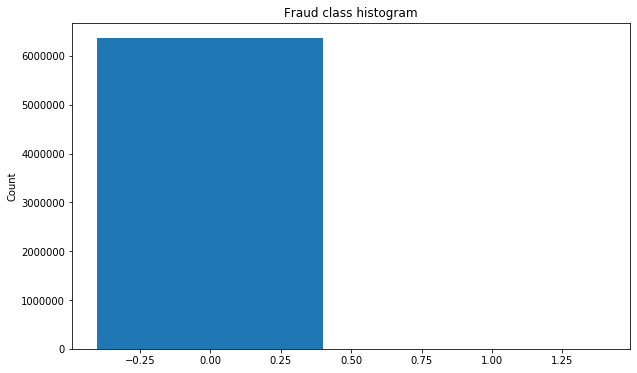

In [14]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6


# Let's start by visualizing the distribution of gender in the dataset.  
fig, ax = plt.subplots()  
x = df.isFraud.unique()  
y = df.isFlaggedFraud.value_counts() 
plt.title('Fraud class histogram')
# Plotting the bar graph  
ax.bar(x, y)  
ax.set_ylabel('Count')  
plt.show()  

###### We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Herein lies the central problem: only a little over 0.1% of these entries are fraudulent.

#### Exploratory Data Analysis
We wrangle with the data to gain insights into the dataset. 

##### Which types of transactions are fraudulent?
We find that of the five types of transactions, fraud occurs only in two of them 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs. 

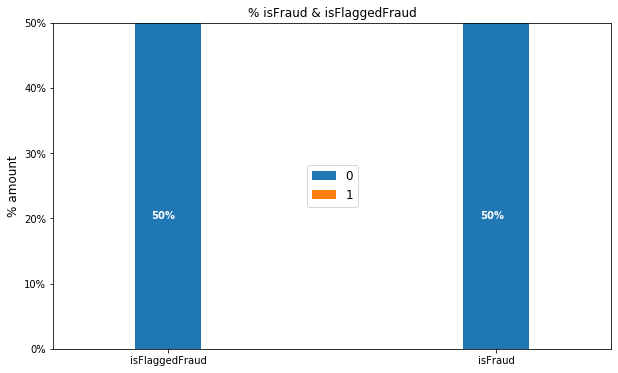

In [15]:
import matplotlib.ticker as mtick # For specifying the axes tick format 
data = pd.melt(df, id_vars=['amount'], value_vars=['isFraud','isFlaggedFraud'])
df1 = data.groupby(['variable','value']).count().unstack()
df1 = df1*100/len(data)
ax = df1.loc[:,'amount'].plot.bar(stacked=True, figsize=(10,6),rot = 0,width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% amount',size = 12)
ax.set_xlabel('')
ax.set_title('% isFraud & isFlaggedFraud',size = 12)
ax.legend(loc = 'center',prop={'size':12})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold')

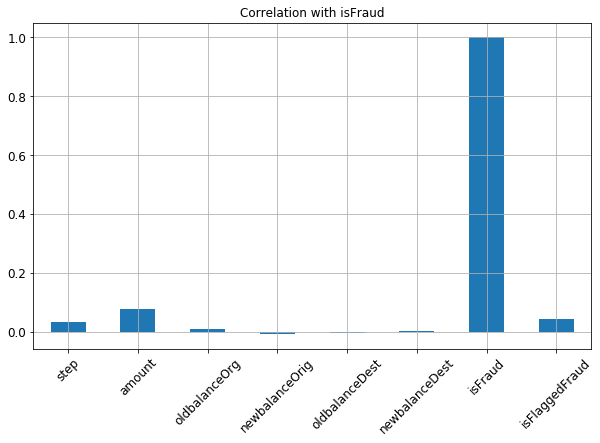

In [16]:
df.corrwith(df.isFraud).plot.bar(
        figsize = (10, 6), title = "Correlation with isFraud", fontsize = 12,
        rot = 45, grid = True)

##### Nonetheless, there seem to be relatively little significant correlations. This can probably be attributed to two factors:
 - The data was prepared using a PCA, therefore our predictors are principal components.
 - The huge class imbalance might distort the importance of certain correlations with regards to our class variable.

In [17]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) 

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) 


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


##### What determines whether the feature isFlaggedFraud gets set or not?
The origin of isFlaggedFraud is unclear, contrasting with the description provided. The 16 entries (out of 6 million) where the isFlaggedFraud feature is set do not seem to correlate with any explanatory variable. The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. In fact, as shown below, isFlaggedFraud can remain not set despite this condition being met.

In [18]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            
dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) 

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) 


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


##### Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set? 
The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. When the record has the isFlaggedFraud = 1, this means that the transaction was detected and stopped from being processed, perhaps that is the reason why it didn't affect the account destination/origin (previous value). Please notice that there is not record of balance from clients that start with M (Merchants). Interestingly, oldBalanceDest = 0 in every such transaction. However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

In [19]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldbalanceDest = 0 and\
 newbalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldbalanceDest == 0) & (dfTransfer.newbalanceDest == 0)]))) 


The number of TRANSFERs where isFlaggedFraud = 0, yet oldbalanceDest = 0 and newbalanceDest = 0: 4158


In [20]:
print('\nMin, Max of oldbalanceOrg for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldbalanceOrg.min()), round(dfFlagged.oldbalanceOrg.max())]))

print('\nMin, Max of oldbalanceOrg for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrg = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
== dfTransfer.newbalanceOrig)].oldbalanceOrg.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceOrg \
               == dfTransfer.newbalanceOrig)].oldbalanceOrg.max())]))


Min, Max of oldbalanceOrg for isFlaggedFraud = 1 TRANSFERs: [353874.0, 19585040.0]

Min, Max of oldbalanceOrg for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrg = newBalanceOrig: [0.0, 575668.0]


##### Can isFlaggedFraud be set based on seeing a customer transacting more than once? 
Here duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.

In [21]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any())) 

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any()))

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))) 


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


It can be easily seen that transactions with isFlaggedFraud set occur at all values of step, similar to the complementary set of transactions. Thus isFlaggedFraud does not correlate with step either and is therefore seemingly unrelated to any explanatory variable or feature in the data.
 
Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

##### Are expected merchant accounts accordingly labelled?
It was stated earlier that CASH_IN involves being paid by a merchant (whose name is prefixed by 'M'). However, as shown below, the present data does not have merchants making CASH_IN transactions to customers.

In [22]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) 


Are there any merchants among originator accounts for CASH_IN transactions? False


In [23]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) 


Are there any merchants among destination accounts for CASH_OUT transactions? False


In [24]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) 

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) 


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

###### Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?
From the data description, the modus operandi for committing fraud involves first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. CASH_OUT involves transacting with a merchant who pays out cash. Thus, within this two-step process, the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT. However, the data shows below that there are no such common accounts among fraudulent transactions. 

In [25]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) 
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


In [26]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldbalanceOrg  \
1030443    65  TRANSFER  1282971.57  C1175896731     1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649      214793.32   
6362556   738  TRANSFER   814689.88  C2029041842      814689.88   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [27]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values)) 


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


The nameOrig and nameDest features neither encode merchant accounts in the expected way, below, we drop these features from the data since they are meaningless.

#### Data cleaning
From the exploratory data analysis (EDA), we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis.

In [3]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 42
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [4]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [36]:
Y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

##### Imputation of Latent Missing Values
The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).

In [5]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & \
(Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldbalanceDest == 0) & \
(XnonFraud.newbalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [6]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = np.nan

In [7]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = np.nan

#### Feature-engineering
There could be a possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we take the data-imputation a step further and create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

In [8]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

In [9]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


#### Data visualization
The best way of confirming that the data contains enough information so that a ML algorithm can make strong predictions, is to try and directly visualize the differences between fraudulent and genuine transactions. Motivated by this principle, I visualize these differences in several ways in the plots below.

In [33]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

#### Dispersion over time
The plot below shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions. Note that the the width of each 'fingerprint' is set by the 'jitter' parameter in the plotStrip function above which attempts to separate out and plot transactions occuring at the same time with different abscissae.

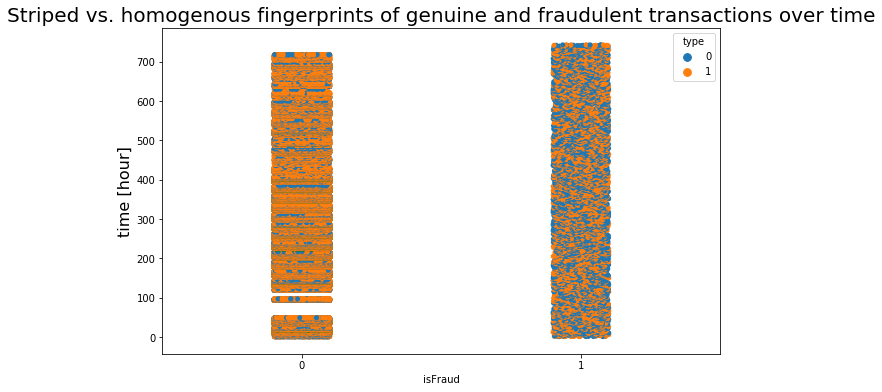

In [34]:
import seaborn as sns
ax = sns.stripplot(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 12)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 12);

#### Dispersion over amount
The two plots below shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction.

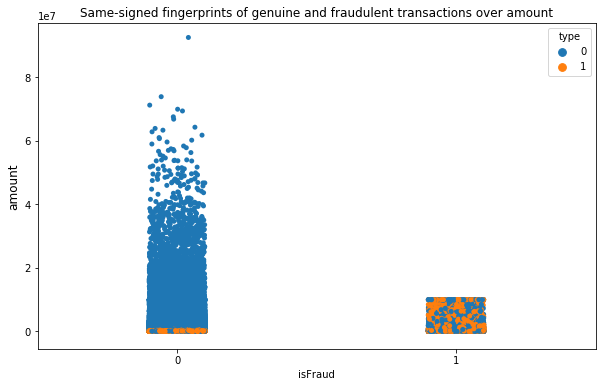

In [35]:
limit = len(X)
ax = sns.stripplot(Y[:limit], X.amount[:limit], X.type[:limit])
ax.set_ylabel('amount', size = 12)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 12);

#### Dispersion over error in balance in destination accounts

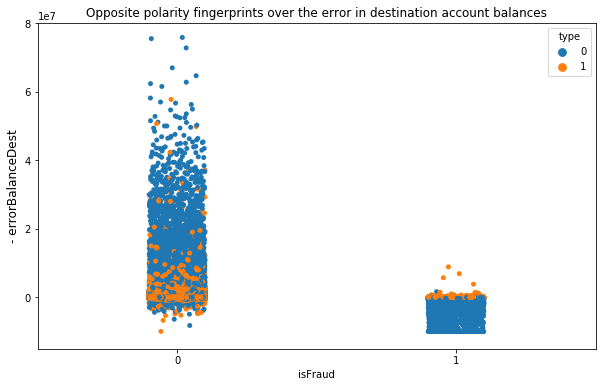

In [36]:
limit = len(X)
ax = sns.stripplot(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], jitter=True)
ax.set_ylabel('- errorBalanceDest', size = 12)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 12);

#### Separating out genuine from fraudulent transactions
The 3D plot below distinguishes best between fraud and non-fraud data by using both of the engineered error-based features. Clearly, the original step feature is ineffective in seperating out fraud. 

In [33]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.lines as mlines 
import seaborn as sns

C:\Users\Sarit\Anaconda3\envs\tensorflow\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\Sarit\Anaconda3\envs\tensorflow\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Sarit\Anaconda3\envs\tensorflow\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Sarit\Anaconda3\envs\tensorflow\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Sarit\Anaconda3\envs\tensorflow\lib\_collections_ab

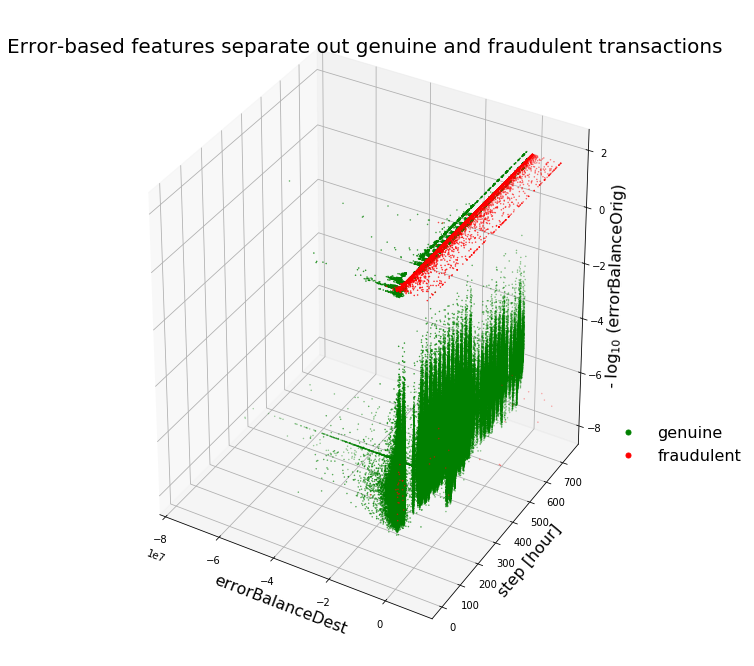

In [34]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraud = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraud = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraud, fraud], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});


#### Fingerprints of genuine and fraudulent transactions
Smoking gun and comprehensive evidence embedded in the dataset of the difference between fraudulent and genuine transactions is obtained by examining their respective correlations in the heatmaps below.

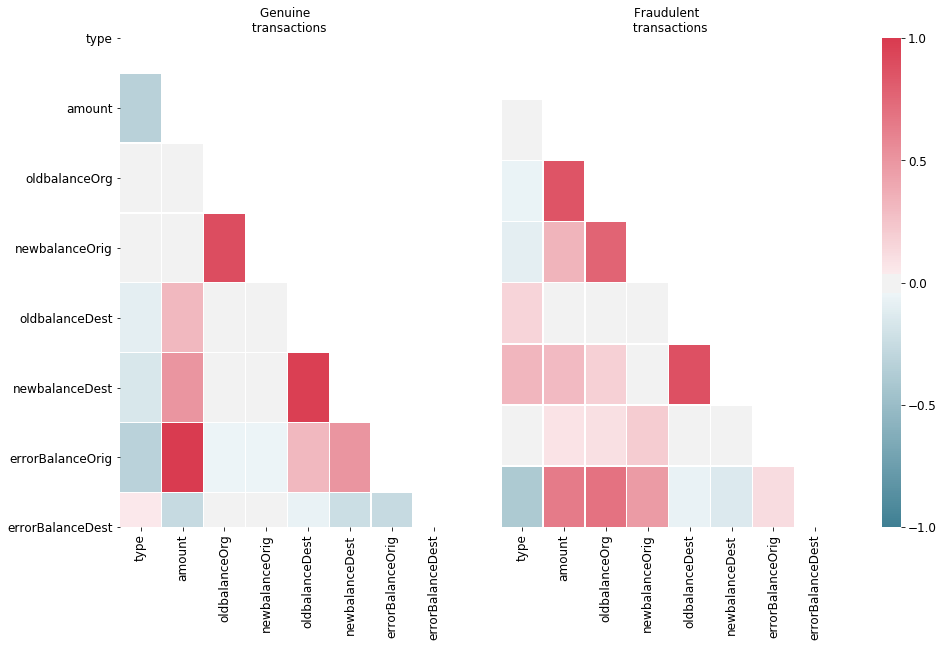

In [37]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 12); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 12); 
ax1.set_title('Genuine \n transactions', size = 12)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 12); 
ax2.set_title('Fraudulent \n transactions', size = 12);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 12);


### Machine Learning to Detect Fraud in Skewed Data
Having obtained evidence from the plots above that the data now contains features that make fraudulent transactions clearly detectable, the remaining obstacle for training a robust ML model is the highly imbalanced nature of the data.

In [38]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


#### Selection of metric 
Since the data is highly skewed, I use the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC). This is because the AUPRC is more sensitive to differences between algorithms and their parameter settings rather than the AUROC (see Davis and Goadrich, 2006).

#### Selection of ML algorithm

A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library. Motivated by this, I tried a variety of anomaly-detection and supervised learning approaches. 

However, from my experience, the best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used below slightly outperforms random-forest. Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class.

Split the data into training and test sets in a 80:20 ratio

In [39]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


In [40]:
Y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

#### Training and Test Set
Now we split the data into training and testing sets according to the percentage and with a random seed we wrote at the beginning of the code. As per best prectice, this should have been done before the exploratory data analysis.

In [10]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [ ]:
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

xgb = XGBClassifier()
logreg2= LogisticRegressionCV(solver='lbfgs', cv=10)
knn = KNeighborsClassifier(5)
svcl = SVC()
adb = AdaBoostClassifier()
dtclf = DecisionTreeClassifier(max_depth=5)
rfclf = RandomForestClassifier()

# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegressionCV(solver='lbfgs', max_iter=5000, cv=10)))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, trainX, trainY, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.996913 (0.000145)
XGB: 0.999987 (0.000007)
KNN: 0.998974 (0.000068)
DT: 0.999974 (0.000007)


### Why XGBoost?
XGBoost uses gradient boosting (GBM) framework at core, yet, does better than GBM framework alone.
 - Parallel Computing: It is enabled with parallel processing (using OpenMP); i.e., when you run xgboost, by default, it would
   use all the cores of your laptop/machine.
 - Regularization: GBM has no provision for regularization which is generally used to avoid overfitting in tree-based models.
 - Missing Values: XGBoost is designed to handle missing values internally. The missing values are treated in such a manner 
   that if there exists any trend in missing values, it is captured by the model.
 - Flexibility: It supports user-defined objective functions also. An objective function is used to measure the performance of
   the model given a certain set of parameters. Furthermore, it supports user defined evaluation metrics as well.
 - Save and Reload: XGBoost gives us a feature to save our data matrix and model and reload it later. Suppose, we have a large
   data set, we can simply save the model and use it in future instead of wasting time redoing the computation.
 - Tree Pruning: XGBoost grows the tree upto max_depth and then prune backward until the improvement in loss function is below
   a threshold.

In [31]:
from xgboost.sklearn import XGBClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
kfold = StratifiedKFold(n_splits=10, random_state=42)
results = cross_val_score(clf, trainX, trainY, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

Accuracy: 99.97% (0.00%)
AUPRC = 0.9967971359933586


##### AUC is 99.67 means there is 99.67% chance that model will be able to distinguish between Fraud and Normal transaction.

In [33]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

# make predictions for test data and evaluate
y_pred = clf.predict(testX)
auc = roc_auc_score(testY, y_pred)
print("Performance (test data) : ", auc)

print ("\nModel Report")
print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(testY, y_pred),3)))
print('Recall: ', round(recall_score(testY, y_pred)*100, 2))
print('\n Classification Report:\n', classification_report(testY, y_pred))

Performance (test data) :  0.9977369656349497

Model Report
Cohen Kappa: 0.954
Recall:  99.57

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.92      1.00      0.95      1646

    accuracy                           1.00    554082
   macro avg       0.96      1.00      0.98    554082
weighted avg       1.00      1.00      1.00    554082



C:\Users\Sarit\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


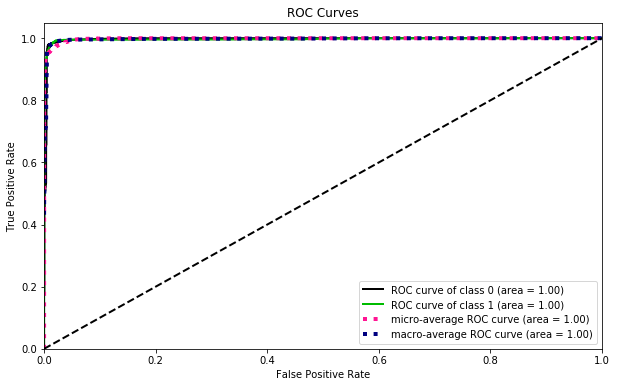

In [51]:
import scikitplot as skplt #to make things easy
y_pred = clf.predict_proba(testX)
skplt.metrics.plot_roc_curve(testY, y_pred)

###### Area Under ROC Curve (AUROC) represents the likelihood of the model distinguishing observations between two classes. 
It gives a single measure of how a model’s true positive rate and false positive rate change with different threshold values. The closer a model’s AUROC score is to 1, the better it is. In the above plot, both are 1.00, suggesting that model has the ability to distiguish between observations from each class.
 - tpr (True positive rate) = TP / TP + FN
Fraction of positive examples correctly classified
 - fpr (false positive rate) = FP / FP + TN
Fraction of negative examples incorrectly classified

The figure below shows that the new feature errorBalanceOrig that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.

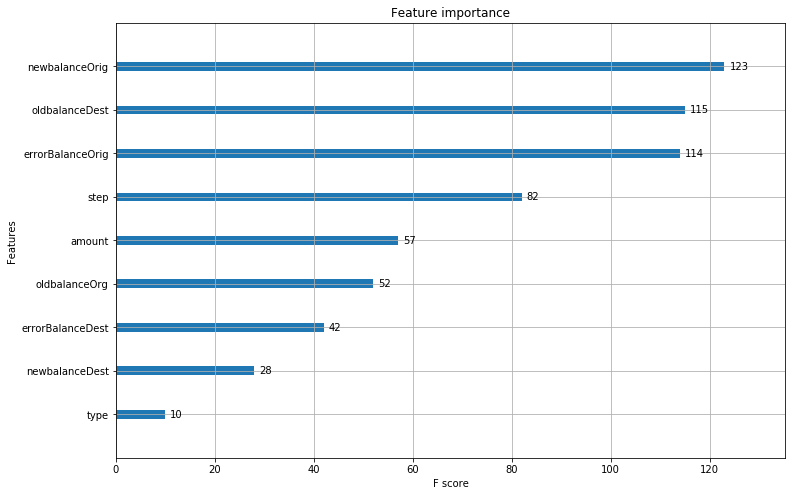

In [60]:
from xgboost import plot_importance
plt.rcParams['figure.figsize'] = [12, 8]
# plot feature importance
plot_importance(clf)

In [61]:
from pprint import pprint
# Check parameters used 
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 4,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 336.3199805186899,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


#### Visualization of ML model
The root node in the decision tree visualized below is indeed the feature errorBalanceOrig, as would be expected from its high significance to the model.

In [53]:
import graphviz
import xgboost as xgb
from xgboost import plot_tree
from matplotlib.pylab import rcParams

In [44]:
import os 
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

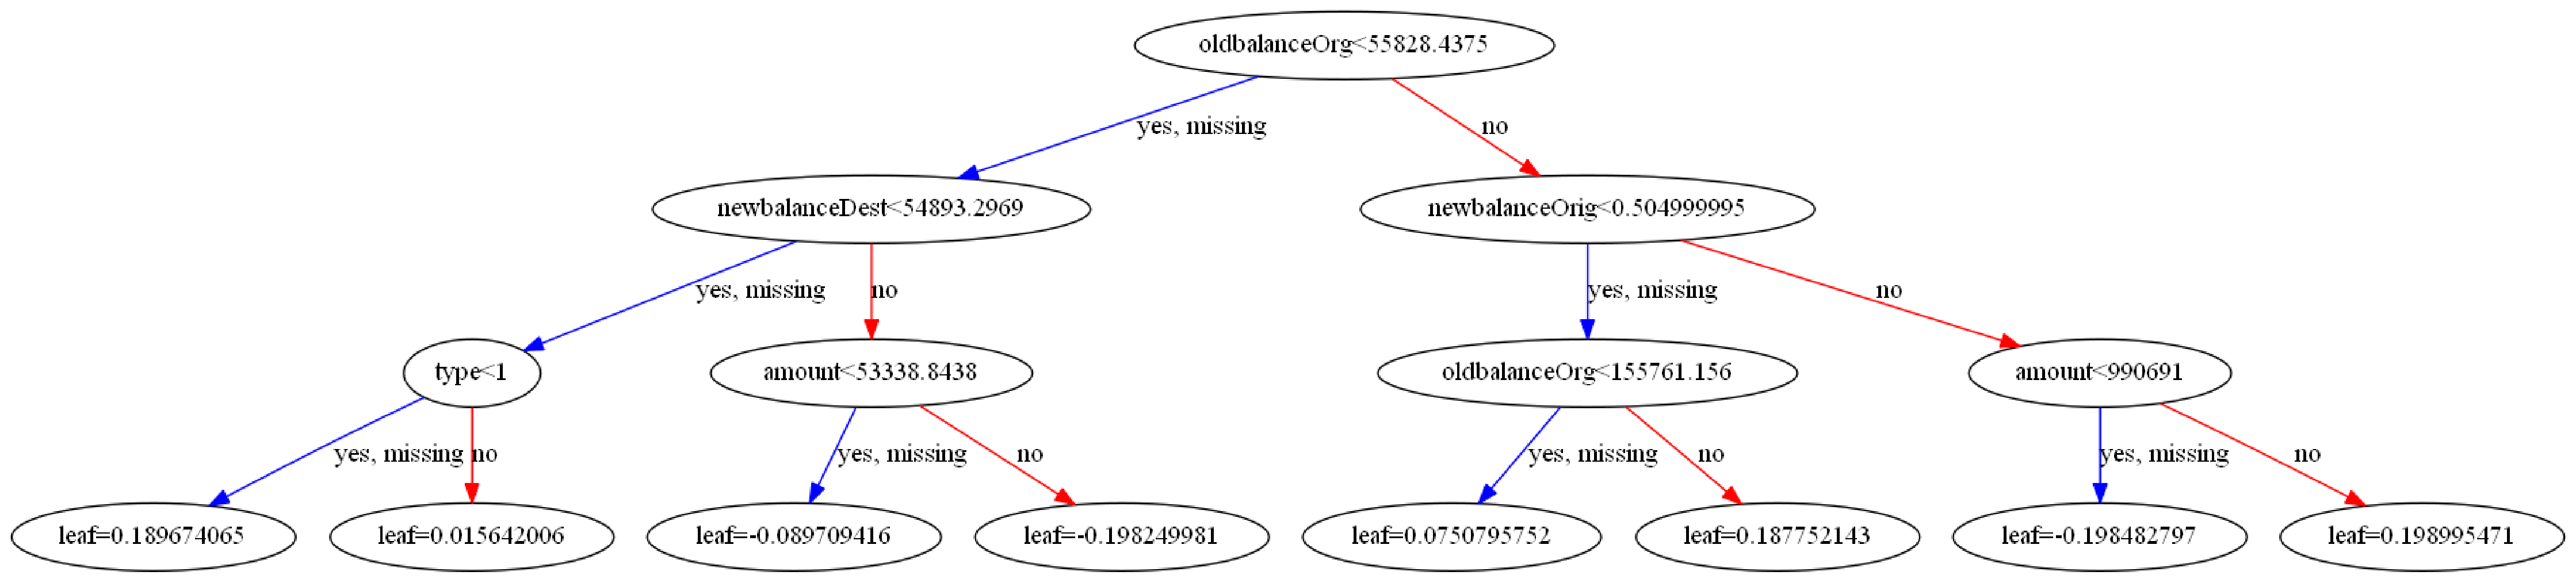

In [54]:
rcParams['figure.figsize'] = 80,50
xgb.plot_tree(clf)

#### Bias-variance tradeoff
In supervised learning, we assume there’s a real relationship between feature(s) and target and estimate this unknown relationship with a model. The goal of the algorithm is to best estimate the mapping function (f) for the output variable (Y) given the input data/parameters (X). In practice,  the relationship is completely unknown, and we try to estimate it with a model. We use a certain training set and get a certain mapping function(f). If we use a different training set, we are very likely to get a different f. As we keep changing training sets, we get different f's for different inputs. The amount by which varies as we change training sets is called variance.

For most real-life scenarios, however, the true relationship between features and target is complicated and far from linear. Simplifying assumptions give bias to a model. The more erroneous the assumptions with respect to the true relationship, the higher the bias, and vice-versa. It can be shown mathematically that both bias and variance can only add to a model’s error.

Generally, a model  will have some error when tested on some test data. This is the prediction error and can be broken down into three parts:
 - Bias Error
 - Variance Error
 - Irreducible Error

The irreducible error cannot be reduced regardless of what algorithm we use. It is the error introduced from the chosen framing of the problem and may be caused by factors like unknown variables that influence the mapping of the input variables to the output variable. GMost of the non-parametric ML algorithms like XGB in this case, have a lot of flexibility and a high variance. We want a low error, so we need to keep both bias and variance at their minimum. However, that’s not quite possible. There’s a trade-off between bias and variance.

To simplify, there is no escape to the relationship between bias and variance in machine learning.
 - Increasing the bias will decrease the variance.
 - Increasing the variance will decrease the bias.
The model we have learnt has a degree of bias and is slighly underfit. This is indicated by the levelling in AUPRC as the size of the training set is increased in the cross-validation curve below. The easiest way to improve the performance of the model still further is to increase the max_depth parameter of the XGBClassifier at the expense of the longer time spent learning the model. Other parameters of the classifier that can be adjusted to correct for the effect of the modest underfitting include decreasing min_child_weight and decreasing reg_lambda.

Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. 
 - max_depth = 3 : I’ve started with 3.
 - min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have
   smaller size groups.
 - gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
 - subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
 - scale_pos_weight = 1: Because of high class imbalance.

In [35]:
from sklearn.model_selection import learning_curve

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = 1, n_jobs = 4, gamma=0,
 subsample=0.8,colsample_bytree=0.8, objective= 'binary:logistic'), trainX,\
                                         trainY, scoring = 'average_precision')

C:\Users\Sarit\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Learning curves')

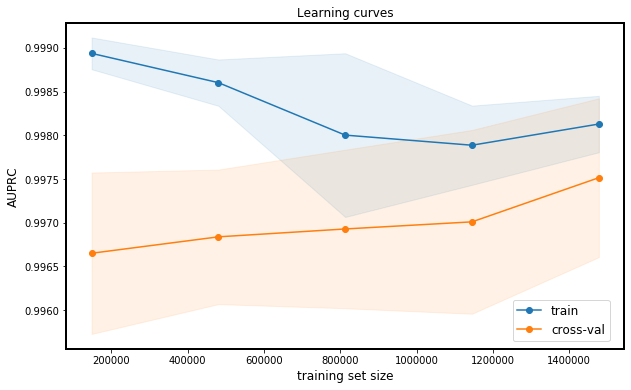

In [36]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (10, 6))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 12)
plt.xlabel('training set size', size = 12) 
plt.ylabel('AUPRC', size = 12)
plt.title('Learning curves', size = 12)


The gap between the learning curves suggests some amount of variance in data. The low training AUPRC score corroborate this diagnosis of variance. The large gap and the low training error also indicates slightly overfitting problem. One more important observation we can make here is that adding new training instances is very likely to lead to better models. The validation curve doesn’t plateau at the maximum training set size used. It still has potential to decrease and converge toward the training curve. So far, we can conclude that our learning algorithm (XGB) suffers from slight variance and quite a low bias, there slightly overfitting the training data. Adding more training instances is very likely to lead to better models under the current learning algorithm.

##### At this point, here are a couple of things we could do to improve our model:
 - Adding more training instances.
 - Increase the regularization for our current learning algorithm. This should decrease the variance and increase the bias.

